In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import os
import pandas as pd

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_PREFIX = "model_"  # Префикс для файлов моделей

def combine_results(data_dir, model_prefix):
    """
    Объединяет результаты всех моделей в один DataFrame.

    Параметры:
        data_dir (str): Путь к папке с данными.
        model_prefix (str): Префикс для файлов моделей.

    Возвращает:
        pd.DataFrame: Объединенный DataFrame с результатами.
    """
    result_df = pd.DataFrame()

    # Поиск всех файлов с указанным префиксом
    file_pattern = os.path.join(data_dir, f"{model_prefix}*_return_series.csv")
    filepaths = [f for f in glob.glob(file_pattern) if os.path.isfile(f)]

    if not filepaths:
        print("Файлы с результатами не найдены.")
        return result_df

    for filepath in filepaths:
        try:
            # Извлекаем название модели из имени файла
            filename = os.path.basename(filepath)
            model_name = filename[len(model_prefix):-len("_return_series.csv")].upper()

            # Читаем данные из файла
            df_tmp = pd.read_csv(filepath)

            # Определяем, какой столбец использовать как дату
            if 'date' in df_tmp.columns:
                date_column = 'date'
            elif 'Close time' in df_tmp.columns:
                date_column = 'Close time'
            else:
                print(f"Файл {filepath} не содержит необходимых столбцов с датой. Пропускаем.")
                continue

            # Определяем столбец с доходностью
            if 'daily_return' in df_tmp.columns:
                value_column = 'daily_return'
            elif len(df_tmp.columns) > 1:  # Если есть второй столбец
                value_column = df_tmp.columns[1]  # Берем второй столбец
            else:
                print(f"Файл {filepath} не содержит необходимого столбца с доходностью. Пропускаем.")
                continue

            # Преобразуем столбец с датой в формат datetime и устанавливаем его как индекс
            df_tmp[date_column] = pd.to_datetime(df_tmp[date_column])
            df_tmp.set_index(date_column, inplace=True)

            # Переименовываем столбец с доходностью в название модели
            df_tmp.rename(columns={value_column: model_name}, inplace=True)

            # Добавляем данные в общий DataFrame
            if result_df.empty:
                result_df = df_tmp
            else:
                result_df = result_df.join(df_tmp, how='outer')

        except Exception as e:
            print(f"Ошибка при обработке файла {filepath}: {e}")
            continue

    # Устанавливаем индекс на основе дат
    if not result_df.empty:
        result_df.index = result_df.index.strftime('%Y-%m-%d')

    return result_df


import glob

# Вызов функции для объединения результатов
combined_results = combine_results(
    data_dir=MODELS_PREDICTION_DIR,
    model_prefix=MODEL_PREFIX
).dropna()

# Выводим результат
print(combined_results)

                 A2C      DDPG  MARKOWITZ       PPO       SAC
2025-01-19  0.000000  0.000000  -0.010010  0.000000  0.000000
2025-01-19 -0.000482 -0.000147  -0.017127 -0.000149 -0.001896
2025-01-19 -0.005453 -0.006504  -0.000049 -0.006072 -0.006898
2025-01-19 -0.006124 -0.005955  -0.006210 -0.006424 -0.006311
2025-01-19 -0.028192 -0.029043  -0.013316 -0.028054 -0.029919
...              ...       ...        ...       ...       ...
2025-04-12 -0.005122 -0.005007  -0.005476 -0.004507 -0.005194
2025-04-12  0.000490  0.000048  -0.003334  0.000446 -0.000350
2025-04-12  0.004435  0.004156   0.003349  0.004324  0.005325
2025-04-12  0.002782  0.002921   0.007698  0.003053  0.002950
2025-04-12  0.001153  0.000508   0.005485  0.000925  0.000800

[1995 rows x 5 columns]


In [3]:
df = combined_results.cumsum()
df

,A2C,DDPG,MARKOWITZ,PPO,SAC
2025-01-19,0.000000,0.000000,-0.010010,0.000000,0.000000
2025-01-19,-0.000482,-0.000147,-0.027137,-0.000149,-0.001896
2025-01-19,-0.005935,-0.006650,-0.027185,-0.006221,-0.008794
2025-01-19,-0.012059,-0.012606,-0.033395,-0.012646,-0.015105
2025-01-19,-0.040251,-0.041649,-0.046711,-0.040699,-0.045023
...,...,...,...,...,...
2025-04-12,-0.504240,-0.549347,-0.603813,-0.519896,-0.569879
2025-04-12,-0.503750,-0.549299,-0.607147,-0.519450,-0.570229
2025-04-12,-0.499316,-0.545143,-0.603799,-0.515127,-0.564904
2025-04-12,-0.496534,-0.542222,-0.596100,-0.512074,-0.561954


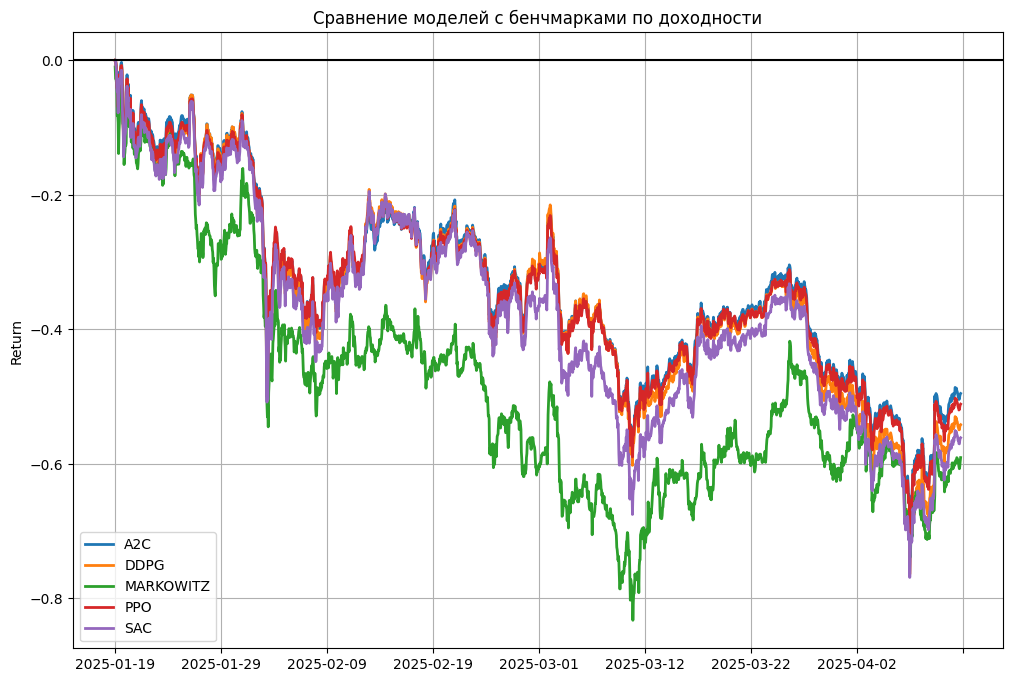

In [4]:

df.plot(linewidth=2, figsize=(12,8))
plt.title('Сравнение моделей с бенчмарками по доходности')
plt.ylabel('Return')
plt.grid()
plt.axhline(y=0, color='black')
plt.show()

In [5]:
print('========== ДОХОДНОСТЬ ==========')
print(df.iloc[-1])

print("\n========== ШАРП ==========")
print(df.iloc[-1] / df.std())

========== ДОХОДНОСТЬ ==========
A2C         -0.495381
DDPG        -0.541714
MARKOWITZ   -0.590616
PPO         -0.511148
SAC         -0.561154
Name: 2025-04-12, dtype: float64

========== ШАРП ==========
A2C         -3.560805
DDPG        -3.641265
MARKOWITZ   -3.539368
PPO         -3.653191
SAC         -3.588774
dtype: float64


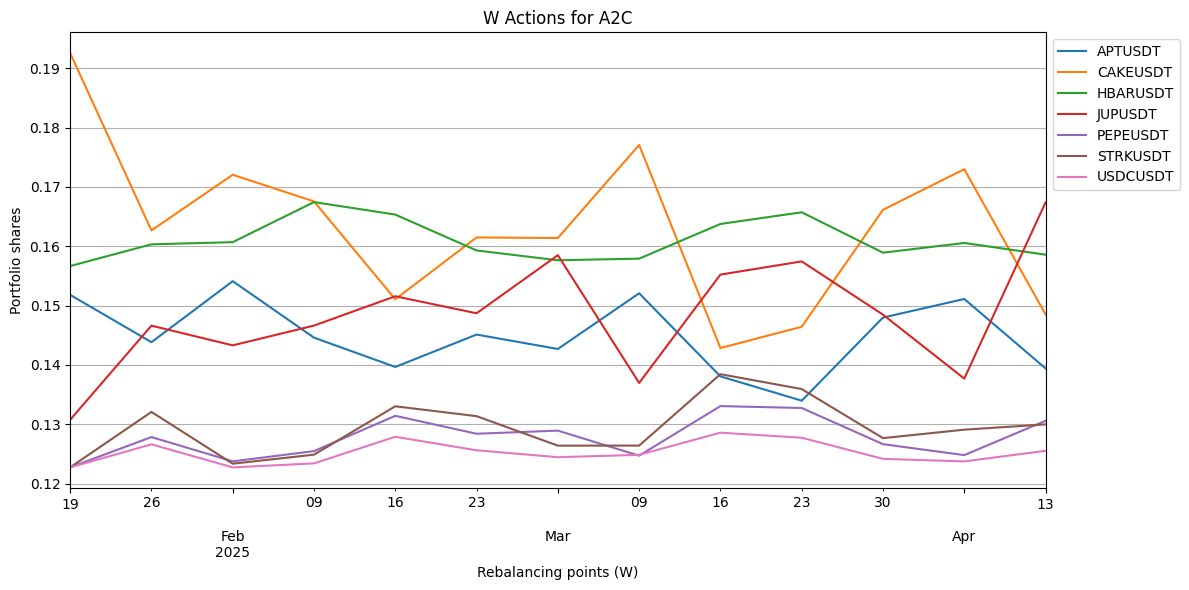

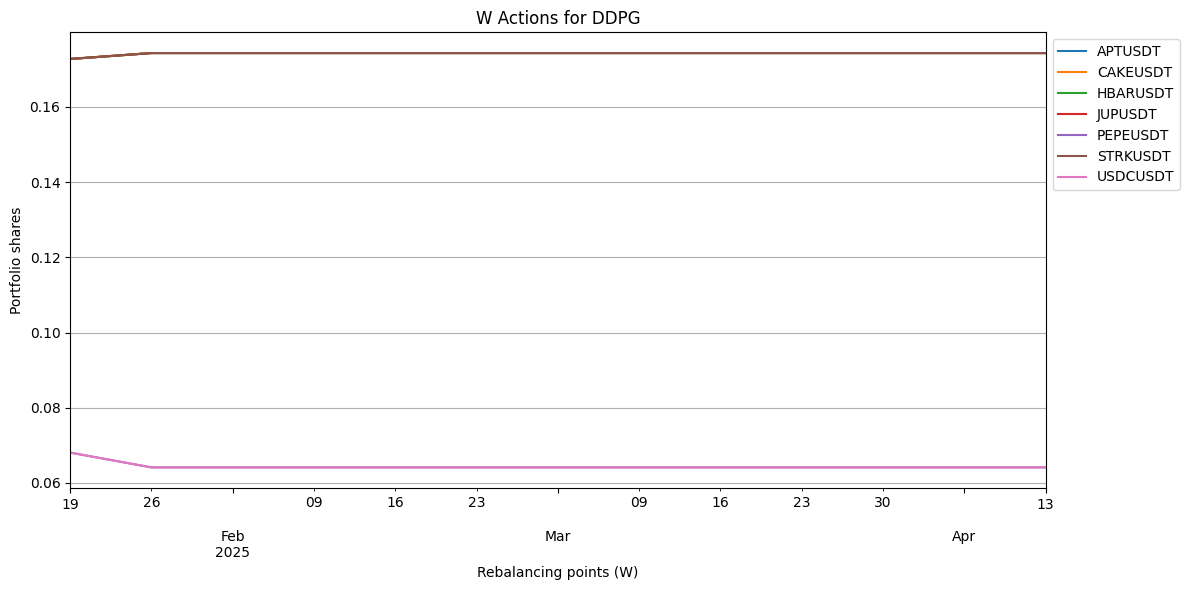

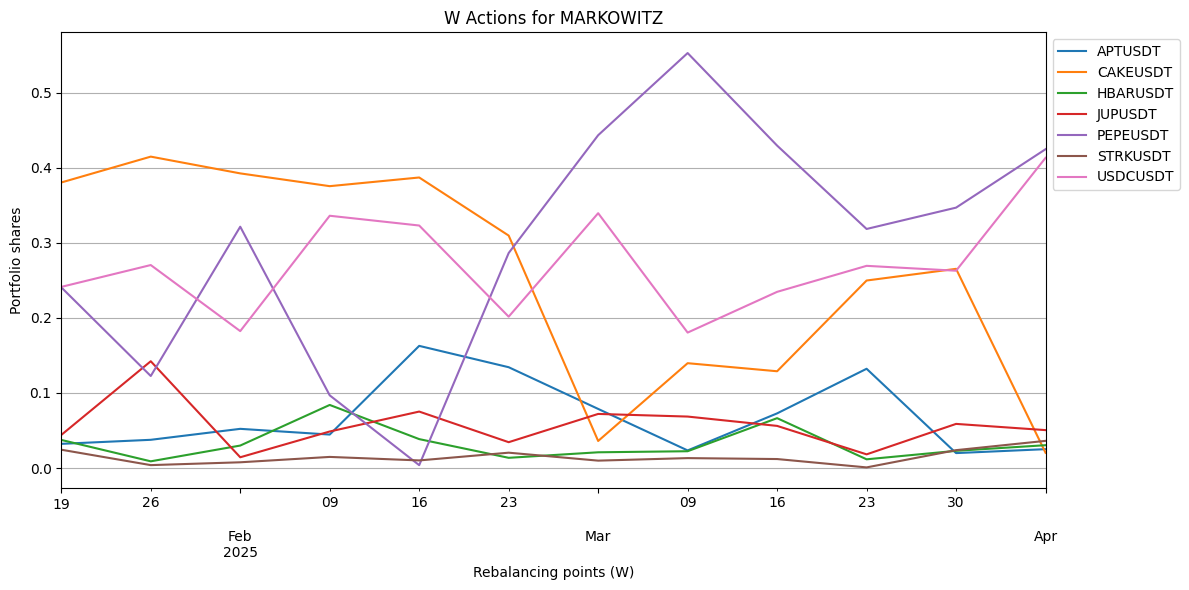

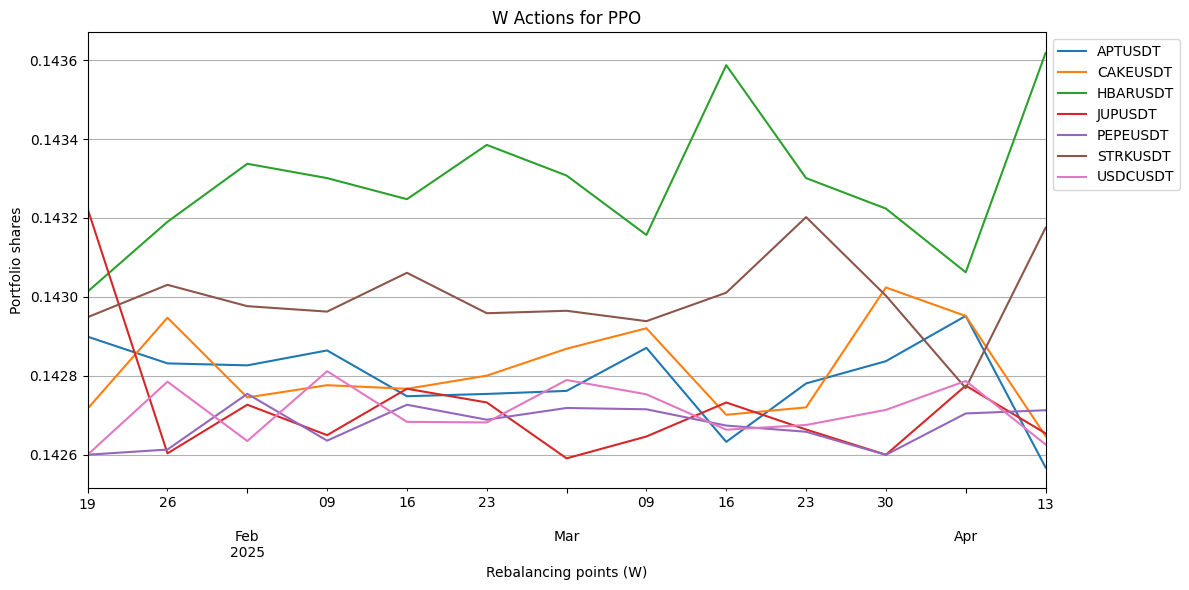

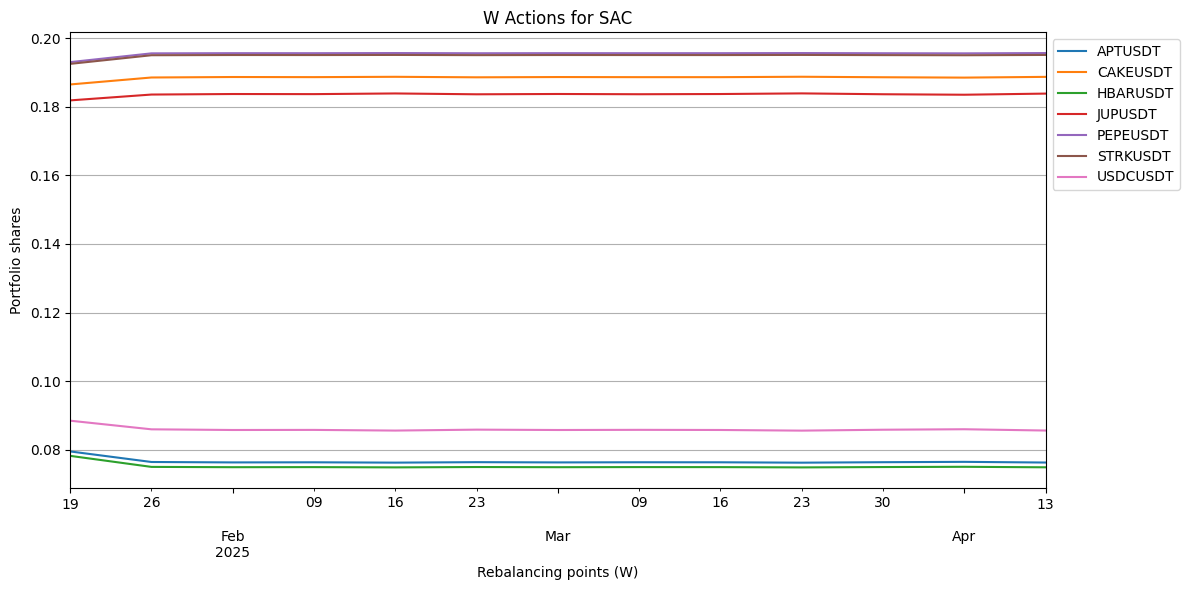

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
MODEL_PREFIX = "model_"  # Префикс для файлов моделей

def plot_hourly_actions(data_dir, model_prefix, resample_period='H'):
    """
    Строит графики действий (долей портфеля) для всех моделей.

    Параметры:
        data_dir (str): Путь к папке с данными.
        model_prefix (str): Префикс для файлов моделей.
        resample_period (str): Период ресемплирования ('H', 'D', 'W').

    Возвращает:
        None
    """
    # Поиск всех файлов с указанным префиксом
    file_pattern = os.path.join(data_dir, f"{model_prefix}*_actions.csv")
    filepaths = [f for f in glob.glob(file_pattern) if os.path.isfile(f)]

    if not filepaths:
        print("Файлы с действиями не найдены.")
        return

    for filepath in filepaths:
        try:
            # Извлекаем название модели из имени файла
            filename = os.path.basename(filepath)
            model_name = filename[len(model_prefix):-len("_actions.csv")].upper()

            # Читаем данные из файла
            actions_df = pd.read_csv(filepath)

            # Убедимся, что столбец 'date' существует
            if 'date' not in actions_df.columns:
                print(f"Файл {filepath} не содержит столбца 'date'. Пропускаем модель {model_name}.")
                continue

            # Преобразуем столбец 'date' в формат datetime и устанавливаем его как индекс
            actions_df['date'] = pd.to_datetime(actions_df['date'])
            actions_df.set_index('date', inplace=True)

            # Ресемплирование данных
            actions_df = actions_df.resample(resample_period).mean()

            # Строим график
            actions_df.plot(figsize=(12, 6), title=f"{resample_period} Actions for {model_name}")
            plt.legend(actions_df.columns, loc='upper left', bbox_to_anchor=(1.0, 1.0))
            plt.grid(axis='y')
            plt.ylabel('Portfolio shares')
            plt.xlabel(f'Rebalancing points ({resample_period})')
            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Ошибка при обработке файла {filepath}: {e}")


import glob

# Вызов функции для построения графиков
plot_hourly_actions(
    data_dir=MODELS_PREDICTION_DIR,
    model_prefix=MODEL_PREFIX,
    resample_period='W'  # 'H' (часовой), 'D' (дневной), 'W' (недельный)
)

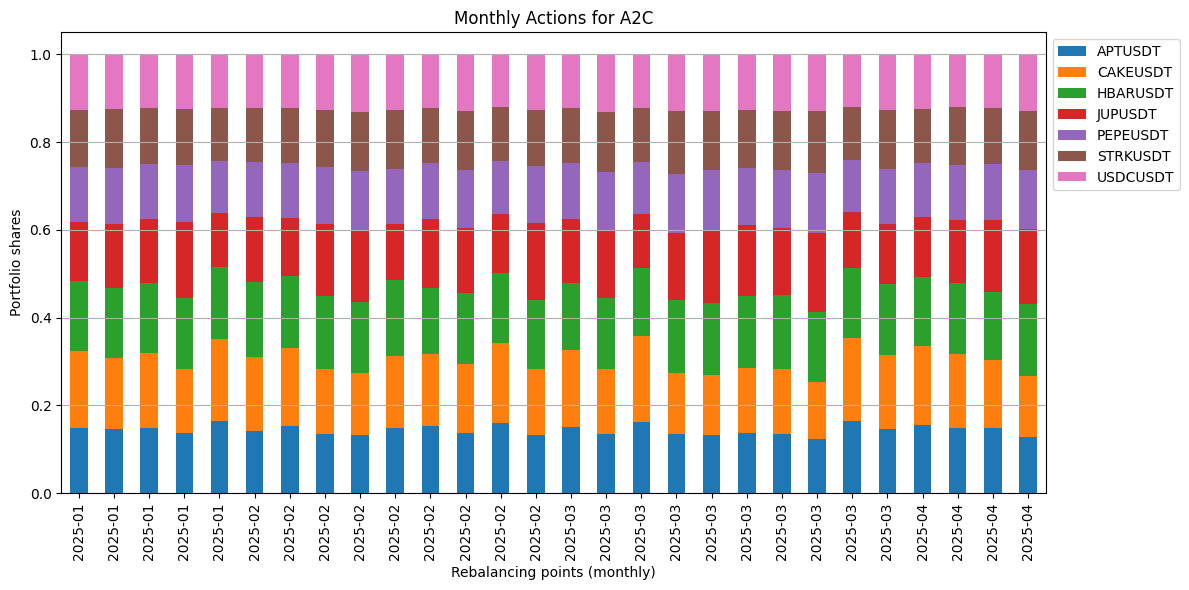

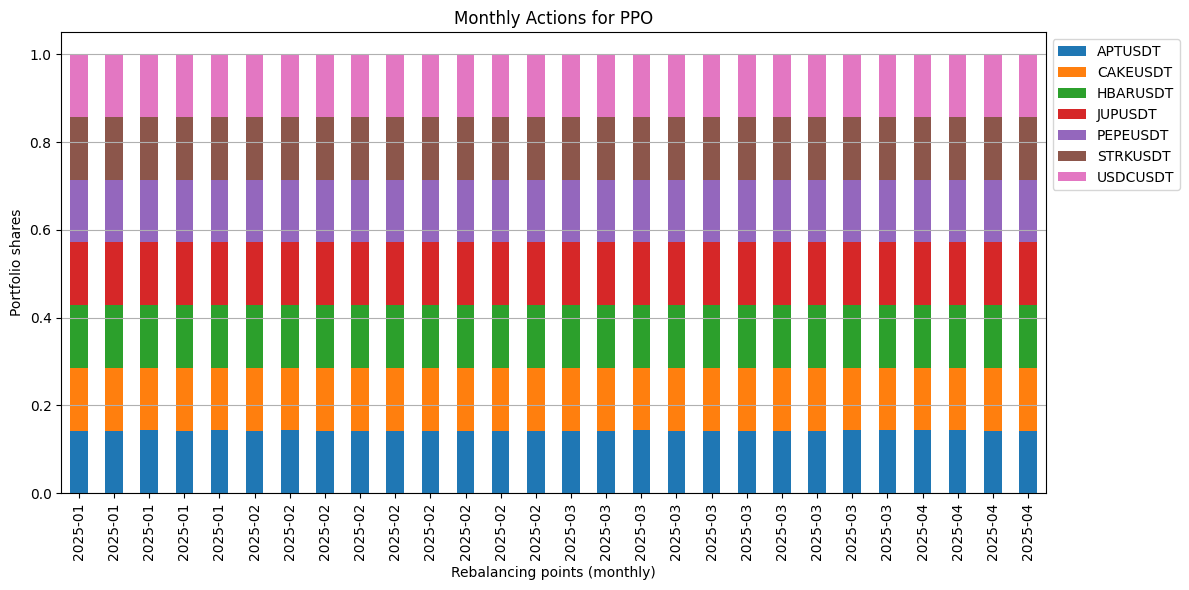

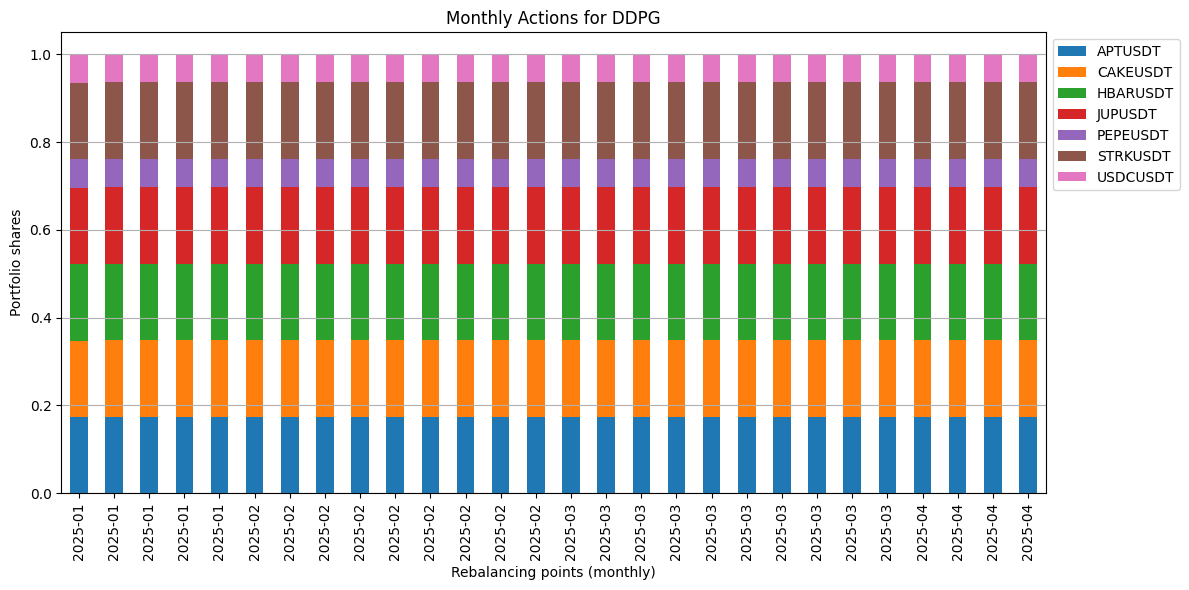

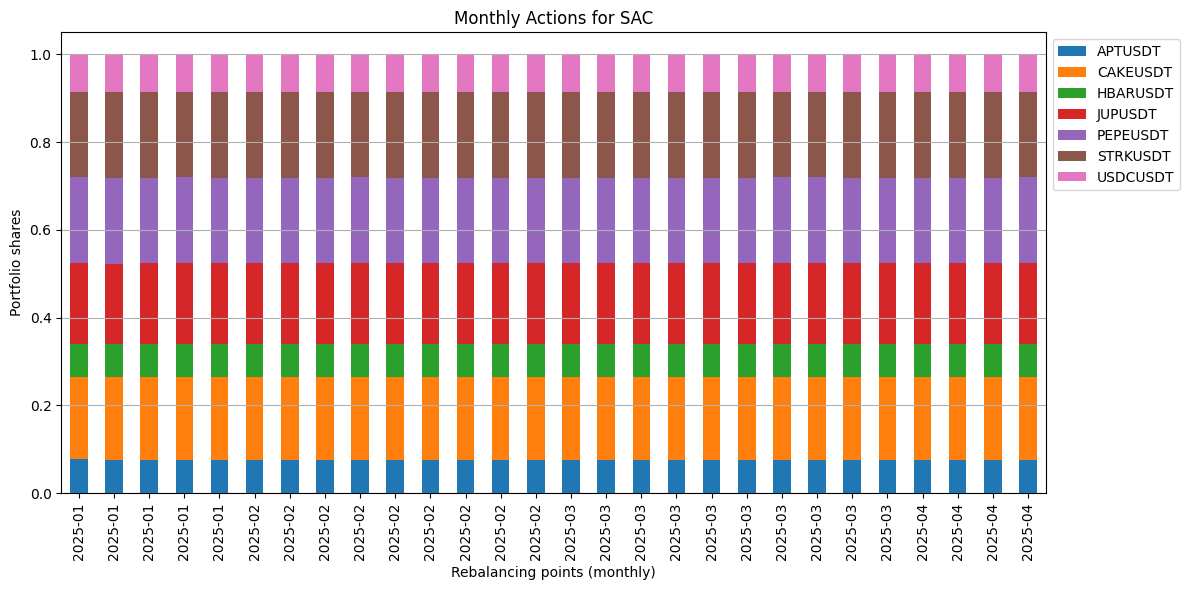

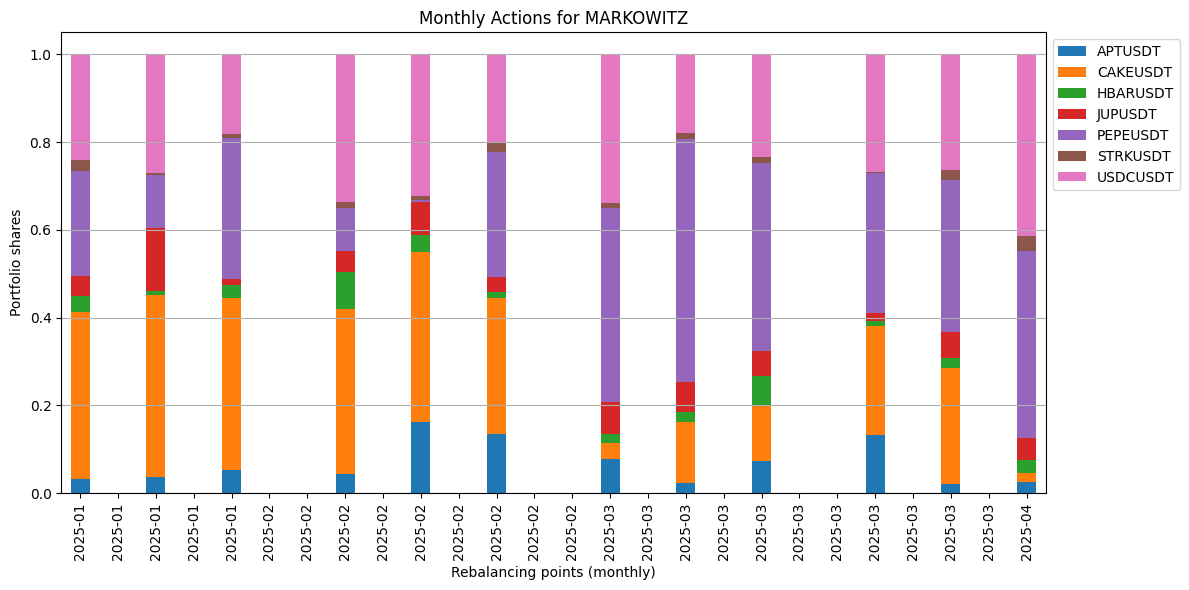

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Конфигурация
DATA_DIR = "../data"
MODELS_PREDICTION_DIR = os.path.join(DATA_DIR, "models_predictions")
DRL_METHODS = ['a2c', 'ppo', 'ddpg', 'sac', 'markowitz']

for method in DRL_METHODS:
    filepath = os.path.join(MODELS_PREDICTION_DIR, f"model_{method}_actions.csv")
    try:
        # Чтение данных
        actions_df = pd.read_csv(filepath)
        actions_df['date'] = pd.to_datetime(actions_df['date'])
        actions_df.set_index('date', inplace=True)

        # Ресемплинг по месяцам и усреднение
        actions_df = actions_df.resample('3D').mean()
        actions_df.index = actions_df.index.strftime('%Y-%m')

        # Построение графика
        actions_df.plot(kind='bar', stacked=True, figsize=(12, 6))
        plt.legend(actions_df.columns, loc='upper left', bbox_to_anchor=(1.0, 1.0))
        plt.grid(axis='y')
        plt.title(f"Monthly Actions for {method.upper()}")
        plt.ylabel('Portfolio shares')
        plt.xlabel('Rebalancing points (monthly)')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Ошибка при обработке файла {filepath}: {e}")